In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Fri Feb 17 13:31:47 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

provider, service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        output=True,   # Print out the available backends
                                       )

from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeSim     = FakeGuadalupe()
simulator        = provider.get_backend('simulator_statevector')
nairobi          = provider.get_backend('ibm_nairobi')
oslo             = provider.get_backend('ibm_oslo')

Available backends
	simulator_stabilizer
	ibmq_manila
	ibm_nairobi
	ibmq_lima
	simulator_mps
	ibmq_belem
	simulator_extended_stabilizer
	simulator_statevector
	ibm_oslo
	ibmq_qasm_simulator
	ibmq_quito


In [3]:
# Import Solution Utilities
import matplotlib.pyplot as plt
import numpy             as np
import rustworkx         as rx

from time import time
from heisenberg_model import HeisenbergModel

from qiskit import transpile, QuantumCircuit
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.circuit.library import EfficientSU2

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

# Local Utilities

In [4]:
# -------------  Statevector visualization and transformations ----------- #
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_bloch_multivector

def qc2Statevector(qc):
    from qiskit import Aer
    qc1 = qc.copy()
    sim = Aer.get_backend('aer_simulator')
    qc1.save_statevector()
    result = sim.run(qc1).result()
    state_vector = result.get_statevector()
    return state_vector
    
def VQE2MiniSvector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe.get_attr('miniAnsatz').assign_parameters(custom_vqe._result.optimal_parameters)
    return qc2Statevector(qc)
    
def VQE2Statevector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe._circuit.assign_parameters(custom_vqe._result.optimal_parameters)
    return qc2Statevector(qc)

def getBlochCoords(state_vector,qubit,num_qubits=None):
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi,r])
    return angles

def getCoords(state_vector, num_qubits=None):
    coords = []
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit,num_qubits=num_qubits))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi

def bloch2cart(pt):
    (r,theta,phi) = np.real(pt)
    xy = r*np.sin(theta)
    x  = xy*np.cos(phi)
    y  = xy*np.sin(phi)
    z  = r*np.cos(theta)
    return x, y, z

def bloch2circuit(angles,nqubits):
    qc = QuantumCircuit(nqubits)
    if len(angles) < nqubits:
        nqubits = len(angles)
    for nbit in range(nqubits):
        (theta, phi,r) = angles[nbit]
        qc.ry(theta,nbit)
        qc.rz(phi,nbit)
    return qc

def bloch2Statevector(angles,nqubits=None):
    if nqubits is None:
        nqubits = len(angles)
    qc = bloch2circuit(angles,nqubits)
    return Statevector(qc)

def getNormedState(custom_vqe,nqubits=None):
    if isinstance(custom_vqe,Statevector):
        init_svector = custom_vqe
    else:
        init_svector = VQE2Statevector(custom_vqe)
    angles = getBlochAngles(init_svector)
    normed_svector = bloch2Statevector(angles,nqubits=nqubits)
    if nqubits is None:
        nqubits = len(angles)
    ravg = 0
    for idx in range(nqubits):
        (theta, phi, r) = angles[idx]
        ravg += r**2
    ravg = np.sqrt(ravg/nqubits) 
    
    return normed_svector, ravg

def displayNormedData(custom_vqe,H=None,nqubits=None):
    from qiskit.quantum_info import state_fidelity
    
    svector = VQE2Statevector(custom_vqe)
    if H is None:
        H=custom_vqe.get_attr('H')
    expSvector = np.real(svector.expectation_value(H))
    normed_svector, ravg = getNormedState(custom_vqe)
    coords = np.real(getCoords(normed_svector))
    expNormed = np.real(normed_svector.expectation_value(H))
    fidelity = state_fidelity(svector,normed_svector)
    print(f"{custom_vqe.label}: {np.around(expSvector,5)} "
          f"Initial    State Energy Level [Bloch(r)={np.around(ravg,3)}]")
    print("---------------------")
    print(f"{custom_vqe.label}: {np.around(expNormed,5)} "
          f"Normalized State Energy Level [Fidelity={np.around(fidelity,3)}]")
    if nqubits is not None:
        normed_svector, ravg = getNormedState(custom_vqe,nqubits=nqubits)

    return plot_bloch_multivector(normed_svector)

# Lattices, Hamiltonians, Ansatze and Optimizers

In [5]:
# Dictionaries for trial elements
hams={}
cells={}
eigenvalue_results={}
Anzs = {}
circuits={}

## Lattices

In [6]:
# Define edge lists for the lattices
t = 1    # All are weighted equally to start
edges_sq = [(0,1,t),(1,2,t),(2,3,t),(3,0,t)]
edges_3 = [(0, 1, t),(0, 2, t),(2, 1, t),]
edges_4 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),]
edges_5 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),(3, 4, t),(1, 4, t)]
edges_12 = [(0, 1, t), (0, 2, t),  (1, 2, t),  (1, 3, t),   (1, 4, t),  (3, 4, t),
            (4, 5, t), (4, 6, t),  (5, 6, t),  (5, 7, t),   (5, 8, t),  (7, 8, t),
            (7, 9, t), (7, 10, t), (9, 10, t), (10, 11, t), (10, 0, t), (11, 0, t) ]
edges_16 = [(1, 2, t),(2, 3, t),(3, 5, t),(5, 8, t),(8, 11, t),(11, 14, t),(14, 13, t),
            (13, 12, t),(12, 10, t),(10, 7, t),(7, 4, t),(4, 1, t),(4, 2, t),(2, 5, t),
            (5, 11, t),(11, 13, t),(13, 10, t),(10, 4, t),]        

# Specify node locations for better visualizations
pos16 = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1],
          1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
          13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
          8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
pos_sq  = { 0:pos16[13], 1:pos16[4], 2:pos16[2], 3:pos16[11], }
pos7_sq = { 0:pos16[13], 1:pos16[4], 2:pos16[2], 3:pos16[11],
            4:[0.5,-1], 5:[1.0,-1], 6:[1.5,-1], }
pos3    = { 0:pos16[13], 1:pos16[10], 2:pos16[12],
            3:[0.5,-1],  4:[0.75,-1], 5:[1.0,-1],  6:[1.25,-1],}
pos4    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7], }
pos4a   = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]], }
pos5    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
            4:pos16[4], }
pos7    = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]],
            4:[0.5,-1],  5:[0.75,-1], 6:[1.0,-1]}
pos12   = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
            4:pos16[4],  5:pos16[2],  6:pos16[1],  7:pos16[5],
            8:pos16[3],  9:pos16[8], 10:pos16[11], 11:pos16[14]}

# Mapping lattice node to device qubits
qbitmap_12_to_16 = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4] # for guadalupe and FakeGuadalupe
qbitmap_4_to_7   = [0,1,2,3]    # For nairobi and oslo
qbitmap_3_to_7   = [0,1,2]      # For nairobi and oslo

## Cells

In [7]:
cells['12_16'] = kagome.create_lattice(16,edges_16)
cells['12_12'] = kagome.create_lattice(12,edges_12)
cells['5_5'] = kagome.create_lattice(5,edges_5)
cells['4_7'] = kagome.create_lattice(7,edges_4)
cells['4_4'] = kagome.create_lattice(4,edges_4)
cells['sq_4'] = kagome.create_lattice(4,edges_sq)
cells['sq_7']  = kagome.create_lattice(7,edges_sq)
cells['3_7'] = kagome.create_lattice(7,edges_3)
cells['3_3'] = kagome.create_lattice(3,edges_3)

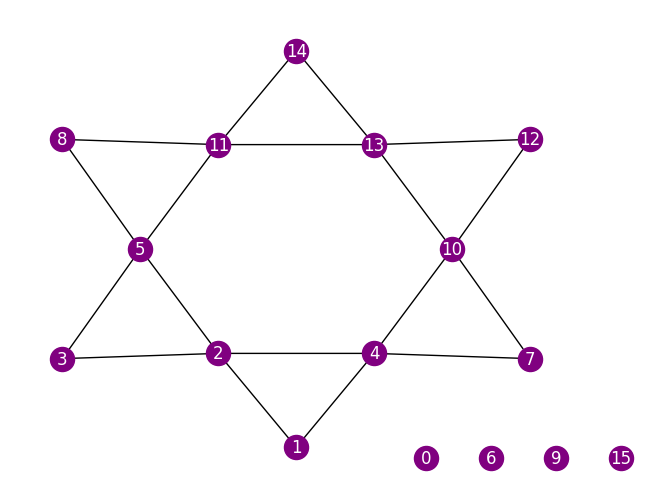

In [8]:
kagome.draw_lattice(cells['12_16'],pos16)

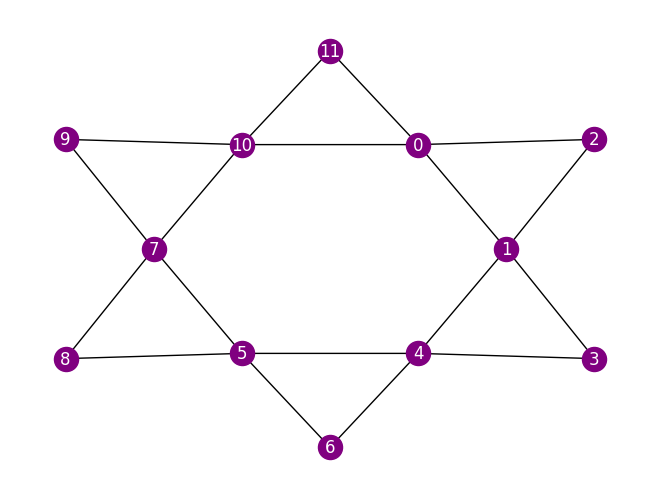

In [9]:
kagome.draw_lattice(cells['12_12'],pos12)

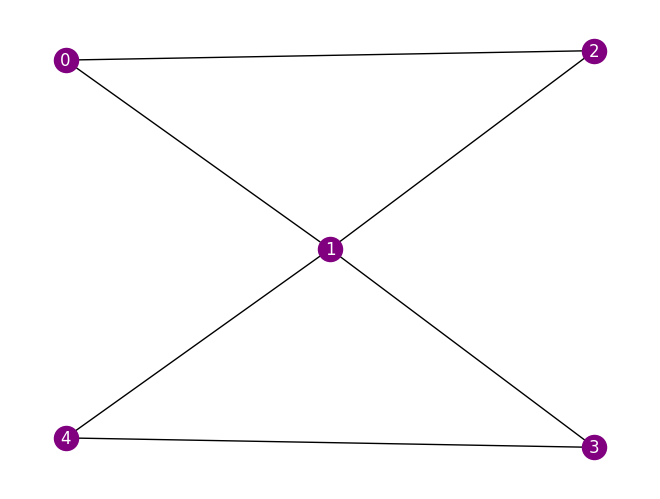

In [10]:
kagome.draw_lattice(cells['5_5'],pos5)

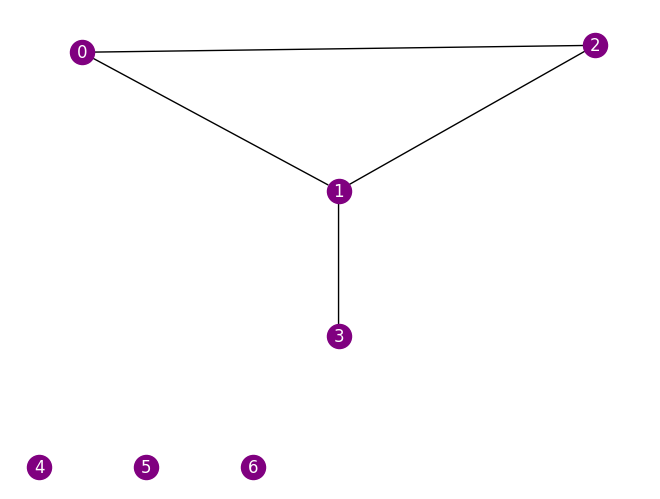

In [11]:
kagome.draw_lattice(cells['4_7'], pos7)

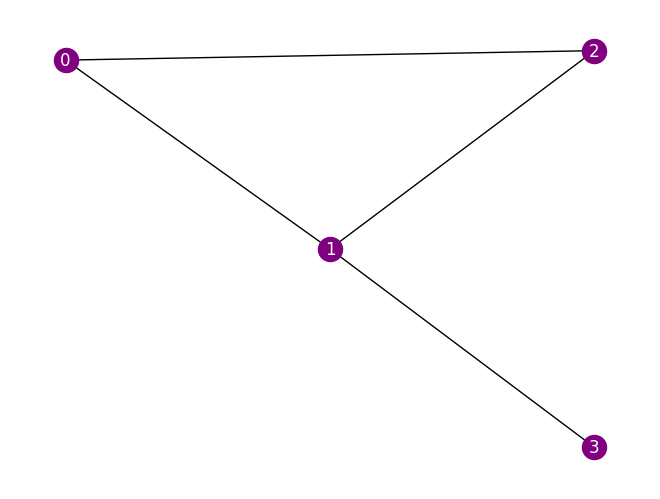

In [12]:
kagome.draw_lattice(cells['4_4'],pos4)

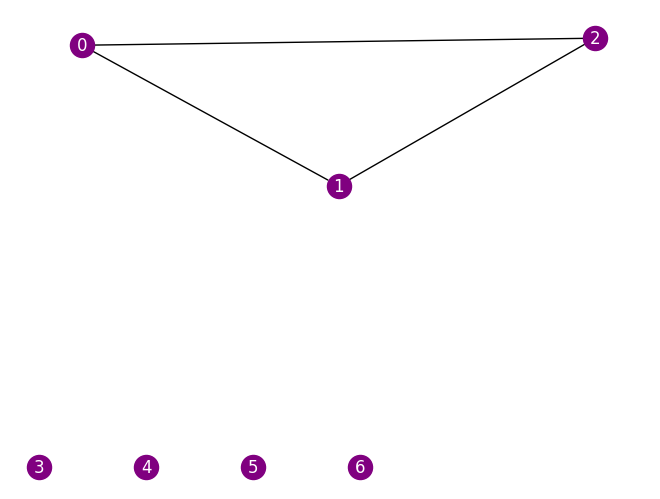

In [13]:
kagome.draw_lattice(cells['3_7'],pos3)

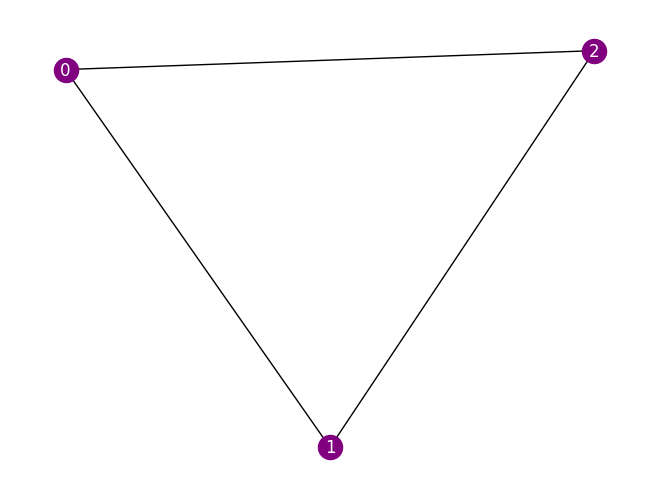

In [14]:
kagome.draw_lattice(cells['3_3'],pos3)

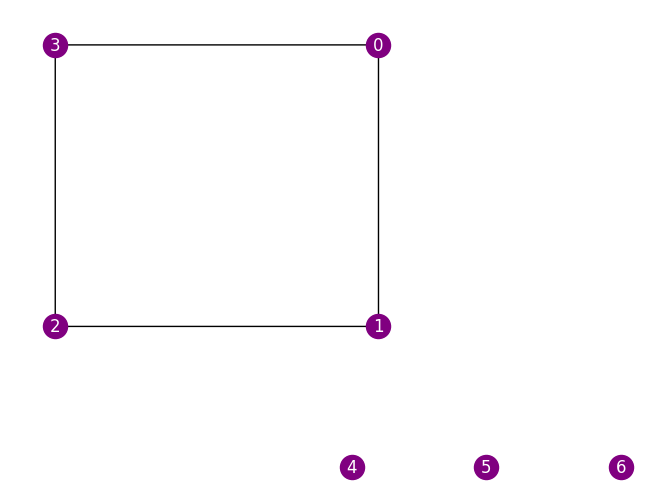

In [15]:
kagome.draw_lattice(cells['sq_7'] ,pos7_sq)

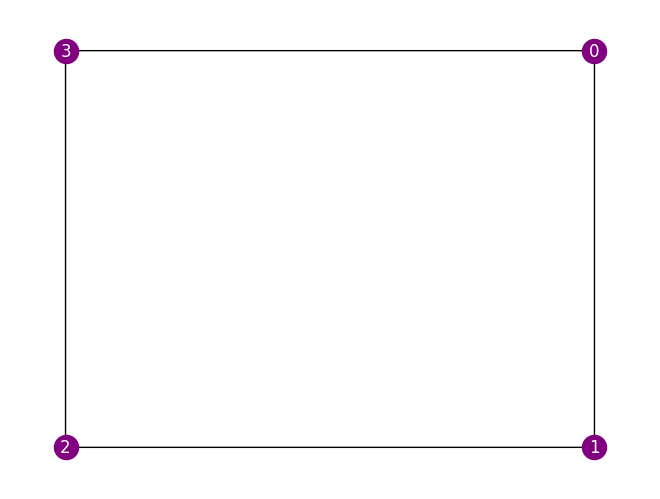

In [16]:
kagome.draw_lattice(cells['sq_4'],pos_sq)

## Hamiltonians

In [18]:
hams['12_12']  = kagome.get_hamiltonian(cells['12_12'])
hams['12_16']  = kagome.get_hamiltonian(cells['12_16'])
hams['4_7']    = kagome.get_hamiltonian(cells['4_7'])
hams['4_4']    = kagome.get_hamiltonian(cells['4_4'])
hams['3_3']    = kagome.get_hamiltonian(cells['3_3'])
hams['sq_4']   = kagome.get_hamiltonian(cells['sq_4'])
hams['sq_7']   = kagome.get_hamiltonian(cells['sq_7'])

print("Hamiltonian Dimensions")
for key,value in hams.items():
    print(f"\t{key}:\t{value.primitive.dim}")


Hamiltonian Dimensions
	12_12:	(4096, 4096)
	12_16:	(65536, 65536)
	4_7:	(128, 128)
	4_4:	(16, 16)
	3_3:	(8, 8)
	sq_4:	(16, 16)
	sq_7:	(128, 128)


## Ansatze

### Custom Ansatz

In [19]:
def display_Ansatz(A):
    def get_Alabel(A,name=None):
        if name is None:
            name = A.name
        return f"{name} n:{3} q:{A.num_qubits} p:{A.num_parameters}" 
    if isinstance(A,dict):
        for key,value in A.items():
            print(f"{get_Alabel(value)} g:{str(dict(value.count_ops()))}")
    else:
        print(f"{get_Alabel(A)} g:{str(dict(A.count_ops()))}")

# Build a custom ansatz from scratch with optional starting circuit
def rotationQC(nqubits, r0, name=''):
    qc=QuantumCircuit(nqubits,name=name)
    for idx in range(1,nqubits):
        _=qc.rx(idx*r0,idx)
    return qc

def rotationIsing(num_qubits,qc=None,layers=3,name='rotationIsing'):
    from qiskit.circuit import Parameter
    if qc is None:
        ansatz = QuantumCircuit(num_qubits)
    else:
        ansatz = qc.copy(name=name)
        num_qubits  = qc.num_qubits
    # Mixing Layers
    j=0
    for i in range(num_qubits):
        if layers > 0:
            ansatz.rx(Parameter('θ_' + str(j)), i)
            j += 1
        if layers > 1:
            ansatz.ry(Parameter('θ_' + str(j)), i)
            j += 1
        if layers > 2:
            ansatz.rz(Parameter('θ_' + str(j)), i)
            j += 1
    return ansatz

def customSU2(num_qubits,qc=None,layers=3,name='customSU2'):
    from qiskit.circuit import Parameter
    if qc is None:
        customSU2 = QuantumCircuit(num_qubits)
    else:
        customSU2 = qc.copy(name=name)
        num_qubits = qc.num_qubits
    # Mixing Layers
    ESU2 = EfficientSU2(num_qubits, entanglement='linear', 
                        reps=layers, skip_final_rotation_layer=True).decompose()
    customSU2 = customSU2.compose(ESU2)
    return customSU2

def customAnsatz2(num_qubits,qc=None,layers=0,name='ansatz2'):
    from qiskit.circuit import Parameter
    if qc is None:
        ansatz2 = QuantumCircuit(num_qubits)
        ansatz2 = ansatz2.extend(customAnsatz1(num_qubits))
    else:
        ansatz2 = qc.copy(name=name)
        num_qubits = qc.num_qubits
    # Mixing Layers
    j = 1
    for l in range(1,layers):
        for i in range(num_qubits):
            ansatz2.rz(Parameter('θ_' + str(j)), i)
            j += 1
            ansatz2.ry(Parameter('θ_' + str(j)), i)
            j += 1
        ansatz2.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz2


def customAnsatz1(num_qubits,name='cust1'):
    from qiskit.circuit import Parameter
    ansatz_custom = QuantumCircuit(num_qubits,name=name)
    # build initial state
    ansatz_custom.h(range(0, num_qubits, 2))
    ansatz_custom.cx(range(0, num_qubits-1, 2), range(1, num_qubits, 2))
    # First layer
    j = 0
    for i in range(num_qubits):
        ansatz_custom.rz(Parameter('θ_' + str(j)), i)
        j += 1
        ansatz_custom.ry(Parameter('θ_' + str(j)), i)
        j += 1
    ansatz_custom.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz_custom

In [20]:
Anzs['A3_SU2'] = EfficientSU2(3, entanglement='linear', reps=3, 
                                 name='A3_SU2',
                                 skip_final_rotation_layer=True).decompose()
Anzs['A3_7_SU2_opt'] = transpile(Anzs['A3_SU2'], backend=nairobi, initial_layout=qbitmap_3_to_7)
Anzs['A3_7_SU2_opt'].name = 'A3_7_SU2_opt'

Anzs['A4_SU2'] = EfficientSU2(4, entanglement='linear', reps=3, 
                                 name='A4_SU2',skip_final_rotation_layer=True).decompose()

Anzs['A4_7_SU2_opt'] = transpile(Anzs['A4_SU2'], backend=nairobi, initial_layout=qbitmap_4_to_7)
Anzs['A4_7_SU2_opt'].name = 'A4_7_SU2_opt'


Anzs['A12_SU2'] = EfficientSU2(12, entanglement='linear', reps=3, 
                       name='A12_SU2',skip_final_rotation_layer=True).decompose()

Anzs['A12_SU2_opt'] = transpile(Anzs['A12_SU2'], backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
Anzs['A12_SU2_opt'].name = 'A12_SU2_opt'

In [21]:
Anzs['A3_cust1']         = customAnsatz1(3,name='A3_cust1')
Anzs['A3_7_cust1']       = transpile(Anzs['A3_cust1'], backend=nairobi, initial_layout=qbitmap_3_to_7)
Anzs['A3_7_cust1'].name  = 'A3_7_cust1'

Anzs['A4_cust1']         = customAnsatz1(4, name='A4_cust1')
Anzs['A4_7_cust1']       = transpile(Anzs['A4_cust1'], backend=nairobi, initial_layout=qbitmap_4_to_7)
Anzs['A4_7_cust1'].name  = 'A4_7_cust1'

Anzs['A12_cust1']        = customAnsatz1(12,name='A12_cust1')
Anzs['A12_16_cust1']      = transpile(Anzs['A12_cust1'], backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
Anzs['A12_16_cust1'].name = 'A12_16_cust1'

display_Ansatz(Anzs)

A3_SU2 n:3 q:3 p:18 g:{'ry': 9, 'rz': 9, 'cx': 6}
A3_7_SU2_opt n:3 q:7 p:18 g:{'rz': 27, 'sx': 18, 'cx': 6}
A4_SU2 n:3 q:4 p:24 g:{'ry': 12, 'rz': 12, 'cx': 9}
A4_7_SU2_opt n:3 q:7 p:24 g:{'rz': 36, 'sx': 24, 'cx': 18}
A12_SU2 n:3 q:12 p:72 g:{'ry': 36, 'rz': 36, 'cx': 33}
A12_SU2_opt n:3 q:16 p:72 g:{'rz': 108, 'sx': 72, 'cx': 33}
A3_cust1 n:3 q:3 p:6 g:{'cx': 3, 'rz': 3, 'ry': 3, 'h': 2}
A3_7_cust1 n:3 q:7 p:6 g:{'rz': 13, 'sx': 8, 'cx': 3}
A4_cust1 n:3 q:4 p:8 g:{'cx': 5, 'rz': 4, 'ry': 4, 'h': 2}
A4_7_cust1 n:3 q:7 p:8 g:{'rz': 16, 'sx': 10, 'cx': 8}
A12_cust1 n:3 q:12 p:24 g:{'cx': 17, 'rz': 12, 'ry': 12, 'h': 6}
A12_16_cust1 n:3 q:16 p:24 g:{'rz': 48, 'sx': 30, 'cx': 17}


# Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

# Boundary Conditions

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


In [22]:
# Create the addtional terms for the Case 1 Hamiltonian
from qiskit.opflow import X, Y, Z, I
# H1_1_4 = 1.0*(I^I^Z^Z) + 1.0*(I^I^Y^Y) + 1.0*(I^I^X^X)

def BoundaryCondition(qbits,K,num_qubits):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.opflow.primitive_ops import PauliSumOp
    # Start with K = I
    coefs = [1.0, 1.0, 1.0]
    op = SparsePauliOp.from_sparse_list([("XX", qbits, coefs[0]), 
                                         ("YY", qbits, coefs[1]),
                                         ("ZZ", qbits, coefs[2])] ,num_qubits=num_qubits)
    H = PauliSumOp(op)
    return H

### 4 Node, Case 1 Boundary Condition: K = I

In [23]:
# Case 1  K = I
H4_4_BCS_C1 = BoundaryCondition([0,1],I,4) + BoundaryCondition([0,3],I,4)
hams['4_4_BC1']  =  hams['4_4'] + H4_4_BCS_C1
cells['4_4_BC1'] = cells['4_4']

H4_7_BCS_C1 = BoundaryCondition([0,1],I,7) + BoundaryCondition([3,0],I,7)
hams['4_7_BC1'] = hams['4_7'] + H4_7_BCS_C1
cells['4_7_BC1'] = cells['4_4']

eigenvalue_results=kagome.compute_eigenvalues(hams,64,force=False,prev_results=eigenvalue_results)
targets = kagome.list_eigenvalues(eigenvalue_results,cells)
kagome.save_object(eigenvalue_results,'eigenvalues.dump')


H12_12: Edges 18 Eigenvalues 64 
	-18.0000:[2]
	-16.9613:[3]
	-16.9449:[6]
	-16.9296:[6]
	-16.8098:[3]
	-16.7353:[1]
	-16.7293:[2]
	-16.5674:[2]
	-16.3117:[3]
	-16.2754:[6]
	-16.2259:[1]
	-16.0412:[6]
	-15.6539:[3]
	-15.4601:[2]
	-15.3308:[3]
	-15.3178:[5]
	-15.1668:[10]

H12_16: Edges 18 Eigenvalues 64 
	-18.0000:[32]
	-16.9613:[25]
	-16.9449:[7]

H4_7: Edges 4 Eigenvalues 64 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]

H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]
	  2.0000:[3]
	  4.0000:[5]

H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]

Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]
	  4.0000:[5]

Hsq_7: Edges 4 Eigenvalues 64 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[32]

H4_4_BC1: Edges 4 Eigenvalues 16 
	 -6.0000:[5]
	 -2.0000:[3]
	  2.0000:[3]
	  6.0000:[5]

H4_7_BC1: Edges 4 Eigenvalues 64 
	 -6.0000:[40]
	 -2.0000:[24]


# Data Runs
## Data Files, Ansatz and Optimizers

# --------------------- Solutions -----------------------------

-------- A4_I_L3 -------------
A[A4_I_L3].expectation(4_4)=0.0 E0=-6.0
-------- A3_I_L1 -------------
A[A3_I_L1].expectation(3_3)=-1.5 E0=-3.0
-------- A3_I0_L1 -------------
A[A3_I0_L1].expectation(3_3)=3.0 E0=-3.0
-------- A3_I1_L1 -------------
A[A3_I1_L1].expectation(3_3)=-1.0 E0=-3.0
-------- A4_I4_L1 -------------
A[A4_I4_L1].expectation(sq_4)=0.0 E0=-8.0
-------- A4_I5_L1 -------------
A[A4_I5_L1].expectation(sq_4)=4.0 E0=-8.0
-------- A4_I6_L1 -------------
A[A4_I6_L1].expectation(4_4_BC1)=-2.0 E0=-6.0
-------- A4_SU2_X0 -------------
-------- A4_SU2_X0 -------------
A[A4_SU2_X0].expectation(4_4_BC1)=6.0 E0=-6.0
-------- A4_SU2_X1 -------------
A[A4_SU2_X1].expectation(4_4_BC1)=-2.0 E0=-6.0
-------- A4_SU2_X2 -------------
A[A4_SU2_X2].expectation(sq_4)=-4.0 E0=-8.0


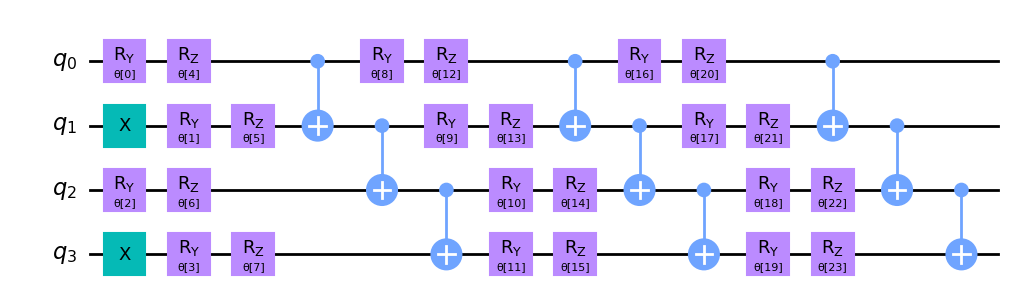

In [54]:

# ------------------------------------------------------------------------------ #
Alabel = 'A4_I_L3'
Hlabel = '4_4'
nqubits=4
circuits[Alabel]=QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x(1)
_=circuits[Alabel].x(3)
Anzs[Alabel]  = rotationIsing(4,qc=circuits[Alabel],name='|0101> A4_Ising_L3',layers=3)
E = Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()

# ------------------------------------------------------------------------------ #
Alabel = 'A3_I_L1'
Hlabel = '3_3'
nqubits=3
r0 = 2*np.pi/3.0
circuits[Alabel] = rotationQC(nqubits,r0,name='|R(pi/3)>')
Anzs[Alabel]  = rotationIsing(nqubits,qc=circuits[Alabel],name='|R(pi/3)> A3_Ising_L1',layers=3)
E = Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
# circuits[Alabel].draw()
Anzs[Alabel].draw()


# ------------------------------------------------------------------------------ #
Alabel = 'A3_I0_L1'
Hlabel = '3_3'
nqubits=3
circuits[Alabel]=QuantumCircuit(nqubits,name='|000>')
Anzs[Alabel]  = rotationIsing(nqubits,qc=circuits[Alabel],name='|000> A3_Ising_L1',layers=3)
E = qc2Statevector(circuits[Alabel]).expectation_value(hams['3_3'])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()

# ------------------------------------------------------------------------------ #
Alabel = 'A3_I1_L1'
Hlabel = '3_3'
nqubits=3
circuits[Alabel]=QuantumCircuit(nqubits,name='|101>')
_=circuits[Alabel].x(range(0, nqubits, 2))
Anzs[Alabel]  = rotationIsing(nqubits,qc=circuits[Alabel],name='|101> A3_Ising_L1',layers=3)
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
# circuits[Alabel].draw()
Anzs[Alabel].draw()

# ------------------------------------------------------------------------------ #
Alabel = 'A4_I4_L1'
Hlabel = 'sq_4'
nqubits=4
r4 = np.pi/2.0
circuits[Alabel] = rotationQC(nqubits,r4,name='|R(pi/2)>')
Anzs[Alabel]  = rotationIsing(nqubits,qc=circuits[Alabel],name='|0xy0> A4_Ising_L1',layers=3)
# angles = getBlochAngles(qc2Statevector(circuits[Alabel]))
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()

# ------------------------------------------------------------------------------ #
Alabel = 'A4_I5_L1'
Hlabel = 'sq_4'
nqubits=4
circuits[Alabel] = QuantumCircuit(nqubits)
Anzs[Alabel] = rotationIsing(nqubits,qc=circuits[Alabel],name='|0000> {Alabel}',layers=3)
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()

# ------------------------------------------------------------------------------ #
Alabel = 'A4_I6_L1'
Hlabel = '4_4_BC1'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x([1,3])
_=circuits[Alabel].rx(np.pi/2.0,2)
Anzs[Alabel] = rotationIsing(nqubits,qc=circuits[Alabel],name=f'|0000> {Alabel}',layers=3)
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()
# ------------------------------------------------------------------------------ #
Alabel = 'A4_SU2_X0'
Hlabel = '4_4_BC1'
nqubits=4
print(f"-------- {Alabel} -------------")
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
Anzs[Alabel] = customSU2(nqubits,qc=circuits[Alabel],layers=3,name=f'|0000> {Alabel}')
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()
# ------------------------------------------------------------------------------ #
Alabel = 'A4_SU2_X1'
Hlabel = '4_4_BC1'
nqubits=4
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x([1,3])
_=circuits[Alabel].rx(np.pi/2.0,2)
Anzs[Alabel] = customSU2(nqubits,qc=circuits[Alabel],layers=3,name=f'|1x10> {Alabel}')
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()
# ------------------------------------------------------------------------------ #
Alabel = 'A4_SU2_X2'
Hlabel = 'sq_4'
nqubits=4
circuits[Alabel] = QuantumCircuit(nqubits,name=Alabel)
_=circuits[Alabel].x([1,3])
Anzs[Alabel] = customSU2(nqubits,qc=circuits[Alabel],layers=3,name=f'|1010> {Alabel}')
E = qc2Statevector(circuits[Alabel]).expectation_value(hams[Hlabel])
print(f"-------- {Alabel} -------------")
print(f"A[{Alabel}].expectation({Hlabel})={np.around(np.real(E),4)} E0={np.around(targets[Hlabel],3)}")
Anzs[Alabel].draw()

In [26]:
# fnameH4_4_BC1 = 'H4_4_BC1.dump'
# fnameH4_4_BCSV = 'H4_4_BCSV.dump'
fnameH_sq4_4   = 'Hsq4_4.dump'

In [66]:
def getX0(p_idx,curCache):
    if isinstance(p_idx,int) and (p_idx > 0) and (p_idx <= len(curCache)):
        x0 = curCache[p_idx]._callback_points[-1]
    elif isinstance(p_idx,str) and (p_idx == '0'):
        x0 = 0
    else:
        x0 = None
    return x0

In [28]:
def quick_plot(data,labels=[],
               title=None, ylim=None, yscale='linear',
               xlabel='Iteration', ylabel='Value', 
               fignum=1, figsize=None,
               colors=['black','red','purple','green']
              ):
    
    if figsize is not None:
        plt.figure(fignum, figsize=figsize)
    data = data if isinstance(data[0],list) else [data]
    if title is not None:
        plt.title(title)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylim is not None:
        plt.ylim(ylim)
    plt.yscale(yscale)
    for idx in range(len(data)):
        label = labels[idx] if len(labels) > idx else ''
        curData = data[idx]
        color = colors[np.mod(idx,len(colors))]
        plt.plot(curData, color=color, lw=2, label=label)
        
    if labels is not None:
        plt.legend()
    plt.grid()
    return plt.show()
 
def quick_scatter(xdata,ydata,fignum=1,figsize=None,
                  xlim=None, ylim=None, 
                  xline=None,yline=None,
                  yscale='linear',
                  xlabel='X Data', ylabel='Y Data'):
    if figsize is not None:
        plt.figure(fignum, figsize=figsize)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if xline is not None:
        plt.axhline(y=xline, color="tab:red", ls="--", lw=2, label="X {xline}" )
    if yline is not None:
        plt.axvline(x=yline, color="tab:red", ls="--", lw=2, label="Y {xline}" )
    plt.yscale(yscale)
    plt.scatter(xdata,ydata)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    return plt.show()

def get_convergence_index(xdata,conv_lim=0.035, conv_ctr=5, offset=1 ):
    conv_indices = np.where(np.array(xdata) < conv_lim )[0]
    #     print(f"found {len(conv_indices)} possibilities\n{conv_indices}")
    idx = offset-1
    conv_idx = None
    #     print(f"Starting search at idx={idx}")
    while (conv_idx is None) and (idx+conv_ctr < len(conv_indices)):
        targetList = list(range(conv_indices[idx],conv_indices[idx]+conv_ctr))
        testList = list(conv_indices[idx:idx+conv_ctr])
        if testList == targetList:
            conv_idx=conv_indices[idx+conv_ctr-1]
        idx+=1
    return conv_idx


# Optimizer Options

In [29]:
optimizers={}
from qiskit.algorithms.optimizers import SPSA
optimizers['01'] = {'opt': SPSA(maxiter=75), 'label':'SPSA(75)' }
optimizers['02'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback), 
                    'label':'SPSA(75,cb)' }
optimizers['03'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(75,cb,block)' }
optimizers['04'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback),
                    'label':'SPSA(150,cb)' }
optimizers['05'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(150,cb,block)' }
optimizers['06'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback),
                    'label':'SPSA(300,cb)' }
optimizers['07'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(300,cb,block)' }
optimizers['08'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(150,cb,trust)' }
optimizers['09'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(300,cb,trust)' }
optimizers['10'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,second_order=True),
                    'label':'SPSA(300,cb,O(2)' }
optimizers['11'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback),
                    'label':'SPSA(100,cb)' }
optimizers['12'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(100,cb,trust)' }

In [120]:
# Results cache and storage
fname    = 'Hsq4_4.dump'
# kagome.save_results([],fname)
curCache = kagome.load_results(fname)

#------------- Problem Setup and Execution ----------------#
Hkey = '4_4_BC1'
target = np.around(targets[Hkey],2)

Akey = 'A4_SU2_X2'   # A4_I6_L1  : A4_SU2_X0 : A4_SU2_X1
miniAnsatz = Anzs[Akey]   # Same as ansatz, no ancially qbits yet

#--- Runtime ---
service = service # None  : service
backend = 'simulator_statevector' # None  : ibm_oslo  : simulator_statevector

#--- Optimizer ---
Okey = '04'   # 150
# Okey = '06'   # 300
# Okey = '09' # 300 trust
# Okey = '07' # 300 block

pt_idx = 'Random' # Start with random vector
# pt_idx = '0'    # Start at 0 vector
# pt_idx = 24 # from last run
x0 = getX0(pt_idx,curCache)  # ['0'] -> 0 vector; [int] -> initial point from cache; else -> Random
label = f"H:{Hkey} A:{Anzs[Akey].name} \nOpt:{optimizers[Okey]['label']} x0={pt_idx}"

if 1:
    custom_vqe = kagome.run_kagomeVQE(hams[Hkey], Anzs[Akey], optimizers[Okey]['opt'], 
                                 miniAnsatz=miniAnsatz,
                                 timeout=None, x0=x0, target=target,
                                 service=service, backend=backend,
                                 resultsList=curCache,
                                 label=label )
    kagome.save_results(curCache,fname)
else: 
    print(label)

Loaded 32 results from Hsq4_4.dump
H:4_4_BC1 A:|1010> A4_SU2_X2 
Opt:SPSA(150,cb) x0=Random idx=32 simulator_statevector SPSA
Runtime 52 min, 57 sec


In [33]:
kagome.list_results(curCache)

0: 'H:sq_4 A:|1x10> A4_SU2_X1 
Opt:SPSA(150,cb) x0=Random idx=0' 	Computed: -6.542	Target:   -8.0	Error 18.223%




Convergence Failure
Duration 52 min, 57 sec Iterations=150 Accepted=100.0 % Rejected=0 min at n=148
Ground State: Computed -5.961 Min -5.96 Expected -6.0
0.65 % Error


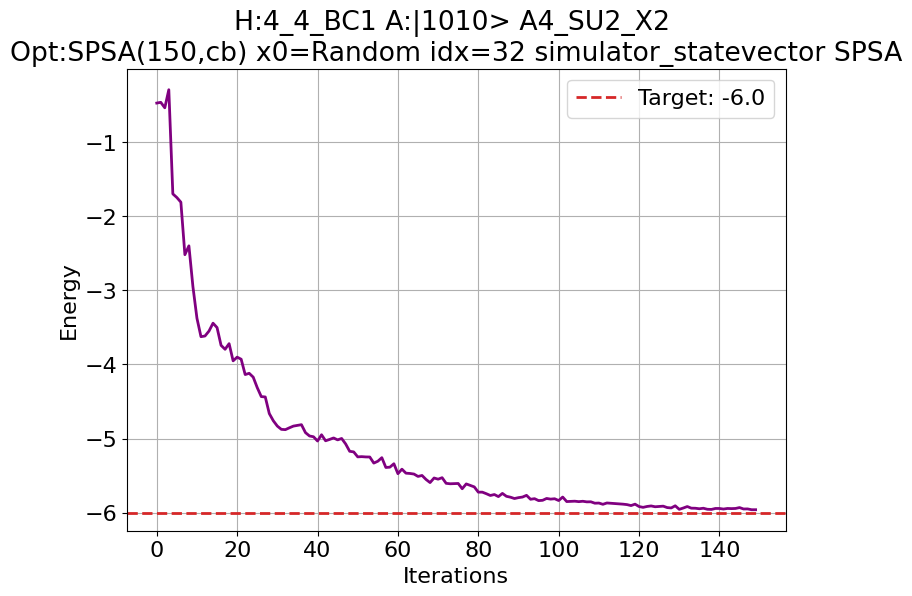

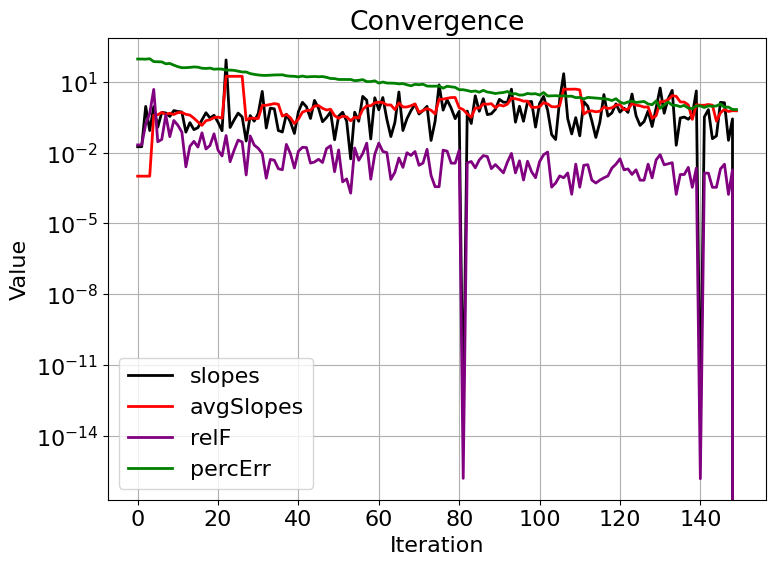

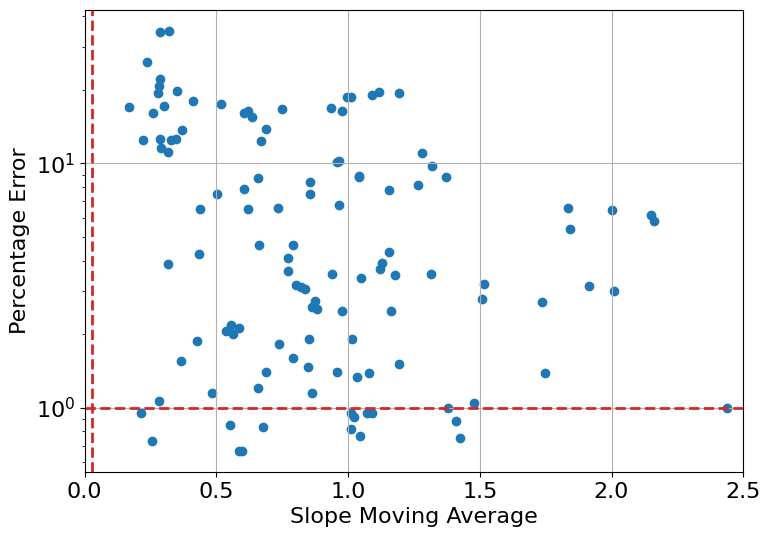

Convergence Failure
Duration 42 min, 13 sec Iterations=150 Accepted=100.0 % Rejected=0 min at n=137
Ground State: Computed -5.988 Min -5.991 Expected -6.0
0.2 % Error


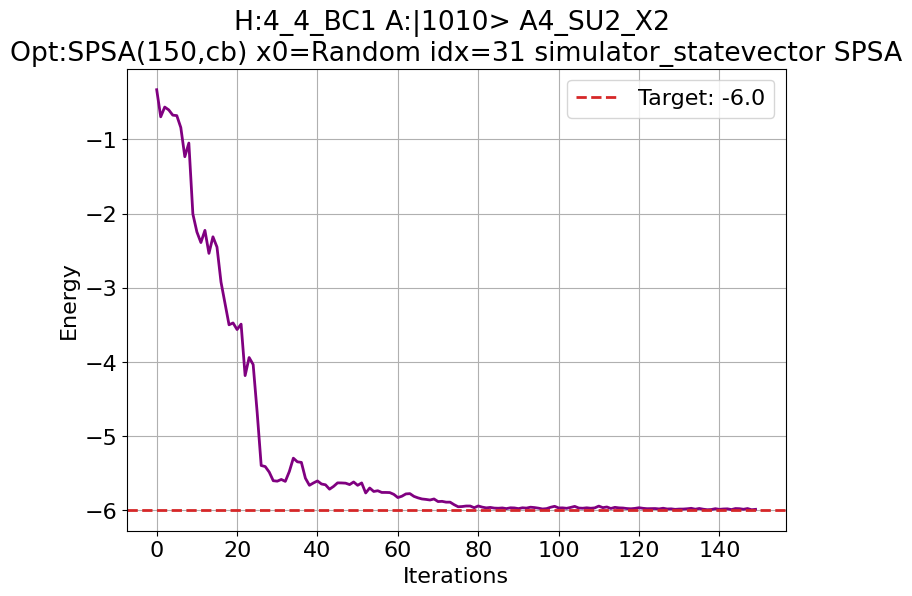

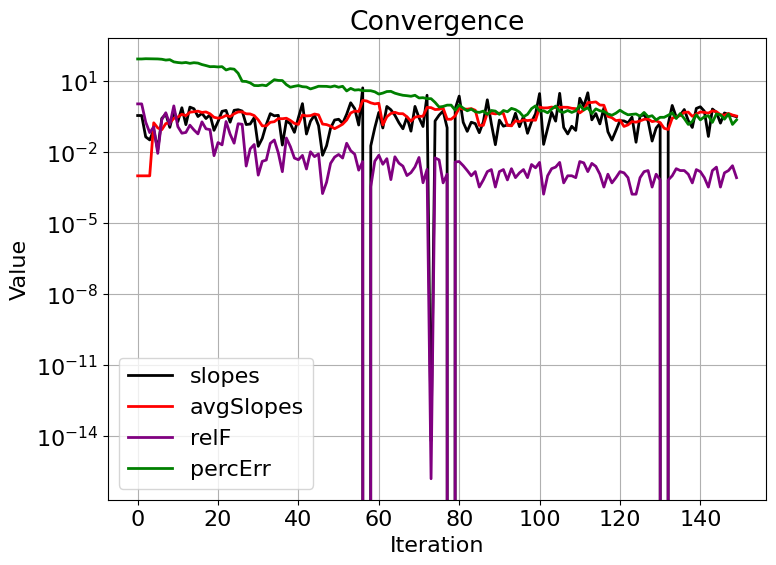

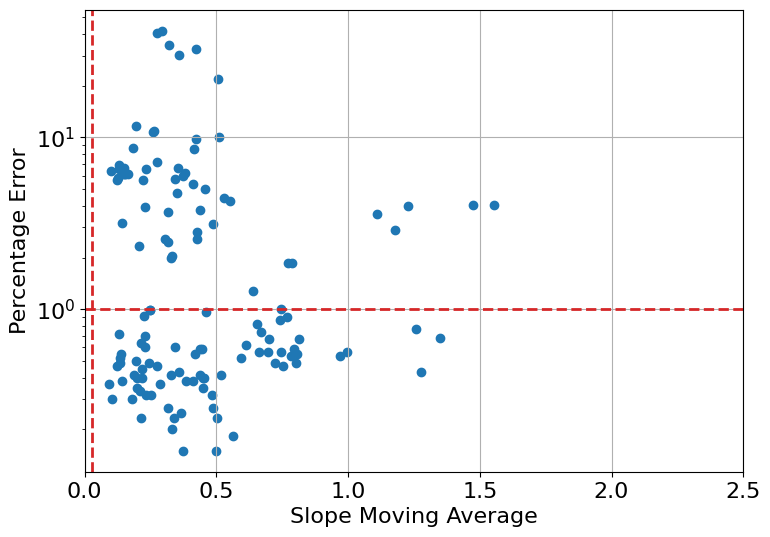

In [140]:
kagome.plot_SPSA_convergence(curCache,
                             indices=[-1,31, ],
                             conv_lim = 0.03,
                             movingAvg=5,
                             perc=6,
                             scatter_xlim=(0,2.5),
                             minStart=20)

In [127]:
def plot_convergence(curCache,indices=[-1],
                     conv_lim = 0.035,
                     movingAvg=5,perc=6,
                     scatter_xlim=(0,0.2),
                     minStart=20):
    figsize=(8.5,6)
    fignum=1
    for idx in indices:
        #===== Get cached data =====#
        curResult = curCache[idx]
        target = curResult.target
        parsed_data = kagome.parse_SPSA_convergence(curResult.SPSA_callback_data,
                                                    mavg=movingAvg,
                                                    target=target)
        # ==== Check for convergence and plot ====
        conv_idx = get_convergence_index(list(np.abs(parsed_data['avgSlopes'])),
                                         conv_lim=conv_lim,conv_ctr=5,offset=movingAvg)
        if conv_idx is not None:
            print(f"Convergence({conv_lim}) at {conv_idx} "
                  f"Fx={np.around(parsed_data['Fa'][conv_idx],perc)} "
                  f"{np.around(parsed_data['percErr'][conv_idx],perc)} % \n")
        else:
            print(f"Convergence Failure")
        kagome.plot_SPSA_callback(curResult,fignum=fignum,figsize=figsize,yline=conv_idx)


        #==== Convergence multiplot ====#
        labels = ['slopes','avgSlopes', 'relF', 'percErr']
        yscale = 'log'
        plotData=[]
        for label in labels:
            data = parsed_data[label]
            if yscale == 'log':
                data = list(np.abs(data))
            plotData.append(data)

        quick_plot(plotData, labels=labels,
                   title='Convergence', ylim=None,
                   fignum=fignum, figsize=figsize,
                   yscale=yscale)

        #==== Convergence Scatter Plots ====
        xdata = list(np.abs(parsed_data['avgSlopes']))[minStart:]
        xlabel='Slope Moving Average'
        ydata = list(np.abs(parsed_data['percErr']))[minStart:]
        ylabel='Percentage Error'    
        quick_scatter(xdata,ydata,
                      xlabel=xlabel, ylabel=ylabel,
                      yscale='log', 
                      xline=1.0, yline=conv_lim,
                      xlim=scatter_xlim,
                      fignum=fignum,figsize=figsize)

In [ ]:
from jTools import cellOutputAll, cellOutputWide
cellOutputAll()
cellOutputWide(60)

In [137]:
import importlib
import jTools
importlib.reload(kagome)
# jTools.cellOutputWide(perc=75)

<module 'kagome' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/kagome.py'>

In [ ]:
idx = -1
curResult = curCache[idx]

plot_bloch_multivector(VQE2MiniSvector(curResult))
displayNormedData(curResult,nqubits=4)

Svector_normed,_= getNormedState(curResult)
coords=getCoords(Svector_normed)
for q_coords in coords:
    print(np.real(q_coords))

# Additional Python Code to Include

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
def Exp(x,A,B):
    return A*np.exp(-1*B*x)

def Linear(x,A,B):
    return A*x + B

def linear_slope(data,npoints,scale=None):
    if npoints < len(data):
        ydata = data[-npoints:]
    else:
        ydata = data
    xdata = np.array(range(len(ydata)))
        
    parameters, covariance = curve_fit(Linear, xdata, ydata)
    if scale is None:
        return parameters[0]
    elif scale > 0:
        return scale*parameters[0]
    else: # Scale as % delta step
        return 100*parameters[0]*ydata[-1]

# Build Ansantz Starting Point